In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def load_Data(link):
    # Load the dataset
    data = pd.read_csv(link)
    data = data.dropna()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    data_train = data[data.index.year <= 2020]
    data_valid = data[(data.index.year == 2021) & (data.index.month <= 6)]
    data_test = data[(data.index.year >= 2021) & (data.index.month > 6)]

    return data_train, data_valid, data_test

In [23]:
def train_model(training_data, window_size = 60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_train_scaled = scaler.fit_transform(training_data)

    X_train = []
    y_train = []

    for i in range(window_size, len(data_train_scaled)):
        X_train.append(data_train_scaled[i-window_size:i, 0])
        y_train.append(data_train_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(16))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, batch_size=1, epochs=5)
    return model, scaler


In [24]:
def preprocess_data(data, scaler, window_size):
    data = data.filter(['Close'])
    data = data.values
    data_scaled = scaler.transform(data)
    X = []
    for i in range (window_size, len(data_scaled)):
        X.append(data_scaled[i-window_size:i, 0])

    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X


In [25]:
def main():

    data =  '/content/drive/MyDrive/TSLA.csv'
    window_size = 60

    data_train, data_valid, data_test = load_Data(data)
    data_valid = pd.concat([data_train.iloc[-window_size:], data_valid], axis=0)
    data_test = pd.concat([data_valid.iloc[-window_size:], data_test], axis=0)

    X_train = data_train.filter(['Close'])
    X_train = X_train.values

    model, scaler = train_model(X_train, window_size)

    X_valid = preprocess_data(data_valid, scaler, window_size)
    y_predict_valid = model.predict(X_valid)
    y_predict_valid = scaler.inverse_transform(y_predict_valid)

    mse = mean_squared_error(y_predict_valid, data_valid['Close'][window_size:])
    print('Mean Squared on valid set:', mse)

    X_test = preprocess_data(data_test, scaler, window_size)

    y_predict_test = model.predict(X_test)
    y_predict_test = scaler.inverse_transform(y_predict_test)

    mse = mean_squared_error(y_predict_test, data_test['Close'][window_size:])
    print('Mean Squared on test set:', mse)


    plt.figure(figsize=(16, 8))
    plt.title('Tesla')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD')
    plt.plot(data_train.index, data_train['Close'], label='Actual Train')
    plt.plot(data_valid.index[window_size:], y_predict_valid, label='Predict Valid')
    plt.plot(data_valid.index[window_size:], data_valid['Close'][window_size:], label='Valid')
    plt.plot(data_test.index[window_size:], data_test['Close'][window_size:], label='Test')
    plt.plot(data_test.index[window_size:], y_predict_test, label='Predict Test')
    plt.legend()
    plt.show()




Epoch 1/5
2587/2587 [==============================] - 23s 8ms/step - loss: 9.2729e-04
Epoch 2/5
2587/2587 [==============================] - 20s 8ms/step - loss: 9.0501e-04
Epoch 3/5
2587/2587 [==============================] - 19s 8ms/step - loss: 4.0367e-04
Epoch 4/5
2587/2587 [==============================] - 20s 8ms/step - loss: 2.2428e-04
Epoch 5/5
4/4 [==============================] - 1s 5ms/step
Mean Squared on valid set: 723.3189910425994
4/4 [==============================] - 0s 4ms/step
Mean Squared on test set: 971.6947729140668


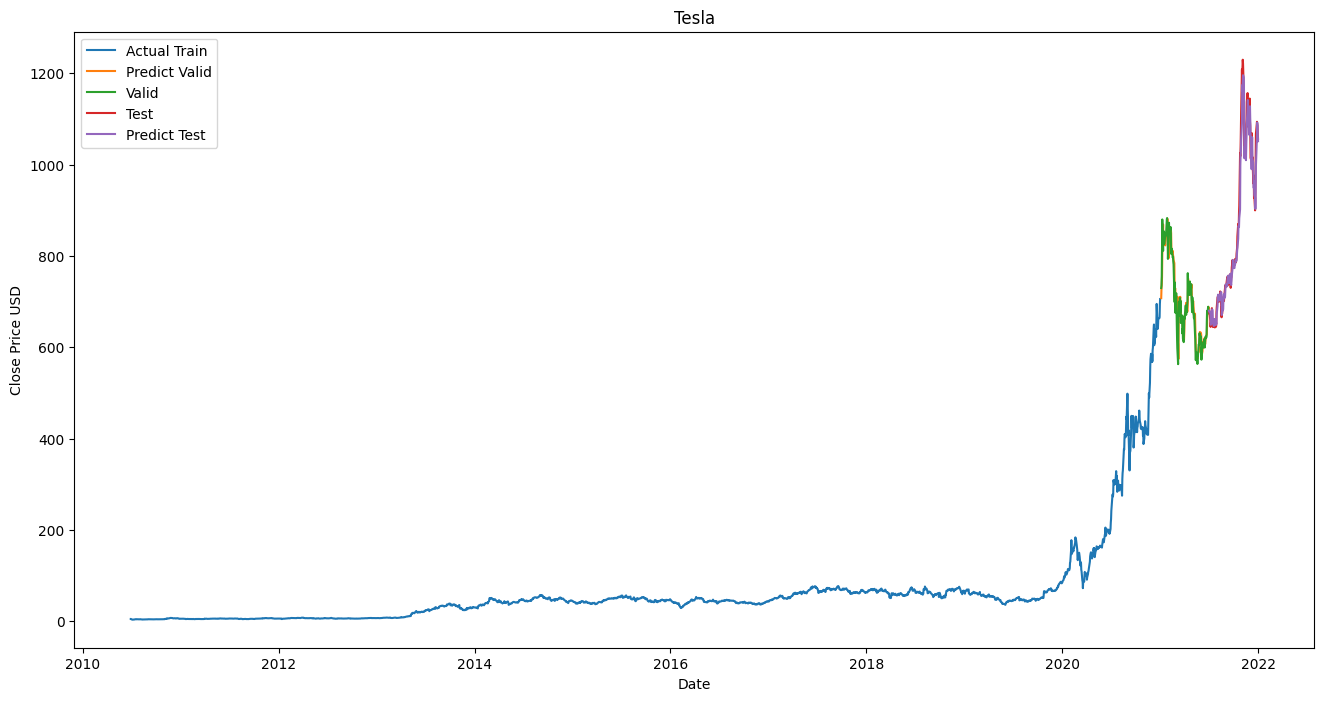

In [28]:
main()